In [1]:
#import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import seaborn as sns

%matplotlib inline

#import conviction files
#from conviction_helpers import *
#from conviction_system_logic3 import *
from bonding_curve_eq import *

System initialization

In [2]:
hatch_raise = 100000 # fiat units
hatch_price = .1 #fiat per tokens
theta = .35 #share of funds going to funding pool at launch

R0 = hatch_raise*(1-theta)
F0 = hatch_raise*theta
S0 = hatch_raise/hatch_price

kappa = 2
V0 = invariant(R0,S0,kappa)
P0 = spot_price(R0, V0, kappa)

agent initialization

In [3]:
#number of agents
n= 100

#gain factors
g = sts.expon.rvs(loc=.1, scale=1, size=n)
phat0 = g*F0/S0

#holdings fiat
h = sts.expon.rvs( loc=10,scale=10, size=n)

#holdings tokens
s_dist = sts.expon.rvs(loc=10, scale=10, size=n)
s0 = s_dist/sum(s_dist)*S0

#lambda for revenue process
lam = 20

#phi for exiting funds
phi = .05

In [4]:
params= {
    'kappa': [kappa],
    'lambda': [lam],
    'gains': [g],
    'population':[n],
    'phi': [phi],
    'invariant': [V0]}

In [5]:
initial_conditions = {'holdings': h,
                      'tokens': s0,
                      'supply': S0,
                      'prices': phat0,
                      'funds':F0,
                      'reserve': R0,
                      'spot_price': P0,
                      'action': {}}

In [6]:
initial_conditions

{'action': {},
 'funds': 35000.0,
 'holdings': array([31.58200339, 29.0449534 , 13.38309347, 39.86546713, 14.46790442,
        11.2871474 , 24.12455596, 12.06277393, 12.62677834, 12.72431123,
        12.0581096 , 23.56626593, 18.71295693, 17.15550518, 12.09218682,
        18.71051653, 42.47594894, 14.9008994 , 19.74554576, 13.16518859,
        23.55333755, 28.66635179, 10.63352331, 64.25158855, 21.33348353,
        13.71217834, 23.71843029, 15.76629049, 35.7052015 , 11.02843696,
        10.317351  , 21.17203975, 25.84668755, 20.01629419, 17.60016477,
        10.31846458, 21.49851613, 13.60206495, 38.73222353, 14.71441894,
        22.65470923, 10.23002233, 12.62138797, 14.37124452, 11.73630219,
        15.02644971, 10.92532854, 46.4010839 , 27.32493113, 32.29756272,
        11.81808269, 27.33989042, 13.99222474, 11.74013444, 12.77155953,
        16.01732288, 34.45910585, 10.73274779, 10.58319649, 21.62325174,
        22.06088202, 46.44276033, 29.903635  , 12.4121705 , 25.91732883,
     

In [7]:
#change in F (revenue and spending accounted for)
def revenue_process(params, step, sL, s):
    lam = params['lambda']
    rv = sts.expon.rvs(scale=1/lam)
    delF= 1-1/lam+rv
    return({'delF':delF})

In [8]:
def update_funds(params, step, sL, s, _input):
    
    funds = s['funds']*_input['delF']
    
    key = 'funds'
    value = funds
    
    return (key, value)

In [9]:
def update_prices(params, step, sL, s, _input):
    
    g = params['gains']
    phat = g*s['funds']/s['supply']
    
    key = 'prices'
    value = phat
    
    return (key, value)

In [10]:
#change in F (revenue and spending accounted for)
def choose_agent(params, step, sL, s):
    n = params['population']
    rv = np.random.randint(0,n)
    return({'agent':rv})

In [11]:
def agent_action(params, step, sL, s, _input):
    
    a = _input['agent']
    h_a = s['holdings'][a]
    phat_a = s['prices'][a]
    s_a =  s['tokens'][a]
    p = s['spot_price']
    
    if p>phat_a:
        mech = 'burn'
        #solve for burn s.t. p=phat
        #if ha is enough
        amt = 10000 #fill in logic here
        if amt> s_a:
            amt = s_a
        
    else: # p<phat_a:
        mech = 'bond'
        #solve for buy s.t. p=phat
        #if sa is enough
        amt = 10000 #fill in logic here
        if amt> h_a:
            amt = h_a
        
    key = 'action'
    value = {'agent':a, 'mech':mech, 'amt':amt}
    
    return (key, value)

In [12]:
def resolve_action(params, step, sL, s):
    action = s['action']
    a = action['agent']
    amt = action['amt']
    h_a = s['holdings'][a]
    s_a =  s['tokens'][a]
    R = s['reserve']
    S = s['supply']
    F = s['funds']
    V0 = params['invariant']
    
    if action['mech'] == 'bond':
        h_a = h_a-amt
        dS, pbar = mint(amt, R,S, V0, params['kappa'])
        R = R+amt
        S = S+dS
        s_a = s_a+dS
        P = spot_price(R, V0, kappa)
    
    elif action['mech'] == 'burn':
        s_a = s_a-amt
        dR, pbar = withdraw(amt, R,S, V0, params['kappa'])
        R = R-dR
        F = F + params['phi']*dR
        S = S-amt
        h_a = h_a + (1-params['phi'])*dR
        P = spot_price(R, V0, kappa)
    
    return({'F':F, 'S':S, 'R':R,'P':P, 'a':a,'s_a':s_a, 'h_a':h_a})

In [13]:
def update_F(params, step, sL, s, _input):
    
    F = _input['F']
    
    key = 'funds'
    value = F
    
    return (key, value)

def update_S(params, step, sL, s, _input):
    
    S = _input['S']
    
    key = 'supply'
    value = S
    
    return (key, value)

def update_R(params, step, sL, s, _input):
    
    R = _input['R']
    
    key = 'reserve'
    value = R
    
    return (key, value)

def update_P(params, step, sL, s, _input):
    
    P = _input['P']
    
    key = 'spot_price'
    value = P
    
    return (key, value)

def update_holdings(params, step, sL, s, _input):
    
    h_a = _input['h_a']
    a = _input['a']
    
    h = s['holdings']
    h[a] = h_a
    
    key = 'holdings'
    value = h
    
    return (key, value)

def update_tokens(params, step, sL, s, _input):
    
    s_a = _input['s_a']
    a = _input['a']
    
    tokens = s['holdings']
    tokens[a] = s_a
    
    key = 'holdings'
    value = tokens
    
    return (key, value)

In [14]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The Partial State Update Blocks
partial_state_update_blocks = [
    { 
        'policies': { 
            #new proposals or new participants
            'random': revenue_process
        },
        'variables': {
            'funds': update_funds,
            'prices': update_prices
        }
    },
    {
      'policies': {
          'random': choose_agent
        },
        'variables': { 
            'action': agent_action, 
        }
    },
    {
      'policies': {
          'act': resolve_action,
        },
        'variables': {
            'funds': update_F, #
            'supply': update_S, 
            'reserve': update_R,
            'spot_price': update_P,
            'holdings': update_holdings,
            'tokens': update_tokens
        }
    }
]

In [15]:
time_periods_per_run = 10000
monte_carlo_runs = 1

from cadCAD.configuration.utils import config_sim
simulation_parameters = config_sim({
    'T': range(time_periods_per_run),
    'N': monte_carlo_runs,
    'M': params
})

In [16]:
from cadCAD.configuration import append_configs
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# The configurations above are then packaged into a `Configuration` object
append_configs(
    initial_state=initial_conditions, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=simulation_parameters #dict containing simulation parameters
)

[{'N': 1, 'T': range(0, 10000), 'M': {'kappa': 2, 'lambda': 20, 'gains': array([4.30267931, 2.31649808, 0.40072669, 0.29947672, 0.79052321,
       0.85710034, 0.71148247, 1.56541014, 0.88381662, 0.93680619,
       3.11524746, 2.63293283, 0.7382524 , 2.05953768, 1.60509151,
       0.37256795, 0.14802233, 0.28160496, 0.36476087, 0.80204989,
       0.98728308, 1.37019036, 0.39278921, 1.13916299, 0.49052357,
       1.39671233, 1.31674289, 0.69602648, 0.45426833, 1.57585358,
       0.79653988, 1.20370353, 1.22985914, 0.1820479 , 5.45725759,
       0.98894992, 0.6326771 , 3.74072733, 0.34143169, 0.40108877,
       1.86675886, 0.31510373, 0.46295893, 0.7622127 , 0.63848493,
       2.16696366, 0.99468836, 0.64567998, 0.38629526, 0.62350857,
       1.94218455, 0.51305449, 2.11880099, 0.79905988, 0.87252215,
       0.34799867, 0.26849755, 1.87345064, 0.9126891 , 0.97781999,
       0.16534882, 0.86135212, 0.23085874, 0.84857163, 1.20828451,
       0.20497155, 2.43340139, 1.37612762, 0.7287905 , 2

In [17]:
from tabulate import tabulate
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD import configs
import pandas as pd

exec_mode = ExecutionMode()
multi_proc_ctx = ExecutionContext(context=exec_mode.multi_proc)
run = Executor(exec_context=multi_proc_ctx, configs=configs)

In [18]:
i = 0
verbose = False
results = {}
for raw_result, tensor_field in run.execute():
    result = pd.DataFrame(raw_result)
    if verbose:
        print()
        print(f"Tensor Field: {type(tensor_field)}")
        print(tabulate(tensor_field, headers='keys', tablefmt='psql'))
        print(f"Output: {type(result)}")
        print(tabulate(result, headers='keys', tablefmt='psql'))
        print()
    results[i] = {}
    results[i]['result'] = result
    results[i]['simulation_parameters'] = simulation_parameters[i]
    i += 1
    


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x1a0e47d390>]
Configurations: [<cadCAD.configuration.Configuration object at 0x1a0e47d390>]


/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:37: RuntimeWarning: invalid value encountered in double_scalars
  realized_price = deltaR/deltaS


In [19]:
experiment_index = 0
df = results[experiment_index]['result']

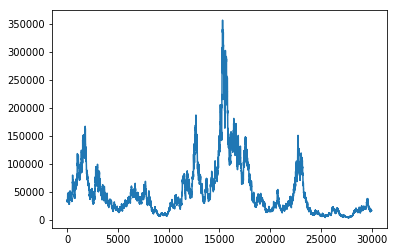

In [20]:
df.funds.plot()

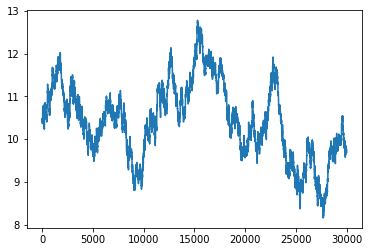

In [21]:
df.funds.apply(np.log).plot()

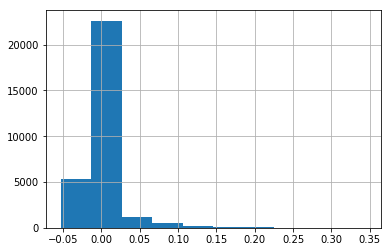

In [22]:
(df.funds.diff()/df.funds).hist()

In [23]:
rdf = df[df.substep == 3]

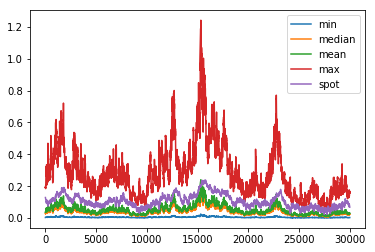

In [24]:
rdf.prices.apply(np.min).plot()
rdf.prices.apply(np.median).plot()
rdf.prices.apply(np.mean).plot()
rdf.prices.apply(np.max).plot()
rdf.spot_price.plot()
plt.legend(['min', 'median','mean','max', 'spot'])

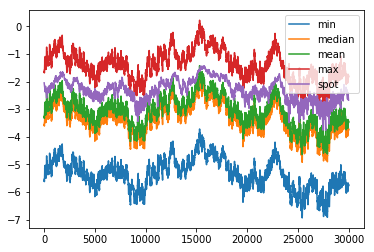

In [27]:
rdf.prices.apply(np.min).apply(np.log).plot()
rdf.prices.apply(np.median).apply(np.log).plot()
rdf.prices.apply(np.mean).apply(np.log).plot()
rdf.prices.apply(np.max).apply(np.log).plot()
rdf.spot_price.apply(np.log).plot()
plt.legend(['min', 'median','mean','max', 'spot'])

In [25]:
rdf.action

3        {'agent': 26, 'mech': 'burn', 'amt': 8311.3033...
6              {'agent': 14, 'mech': 'burn', 'amt': 10000}
9        {'agent': 29, 'mech': 'burn', 'amt': 5264.6786...
12              {'agent': 4, 'mech': 'burn', 'amt': 10000}
15             {'agent': 16, 'mech': 'burn', 'amt': 10000}
18             {'agent': 52, 'mech': 'burn', 'amt': 10000}
21             {'agent': 11, 'mech': 'burn', 'amt': 10000}
24             {'agent': 46, 'mech': 'burn', 'amt': 10000}
27       {'agent': 77, 'mech': 'burn', 'amt': 7100.5072...
30       {'agent': 90, 'mech': 'burn', 'amt': 9912.5936...
33       {'agent': 33, 'mech': 'burn', 'amt': 9816.5368...
36             {'agent': 81, 'mech': 'burn', 'amt': 10000}
39             {'agent': 93, 'mech': 'burn', 'amt': 10000}
42       {'agent': 10, 'mech': 'bond', 'amt': 12.058109...
45       {'agent': 69, 'mech': 'burn', 'amt': 5870.6208...
48             {'agent': 17, 'mech': 'burn', 'amt': 10000}
51             {'agent': 16, 'mech': 'burn', 'amt': 1000

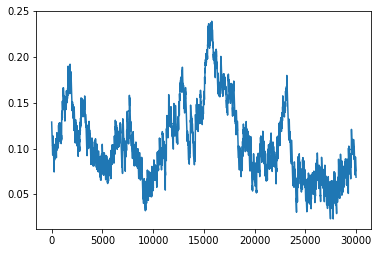

In [26]:
rdf.spot_price.plot()